In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_analysis_codes import param
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)

In [2]:
pk1_04 = param.dust_k1_04()
pk1_06 = param.dust_k1_06()
pk1_10 = param.dust_k1_1()

pk2_04 = param.dust_k2_04()
pk2_06 = param.dust_k2_06()
pk2_10 = param.dust_k2_1()

pk4_04 = param.dust_k4_04()
pk4_06 = param.dust_k4_06()
pk4_10 = param.dust_k4_1()

In [3]:
class FFTClass:
    def __init__(self, p):
        self.p = p
        self.path = '/home/robynm/simulations/S1/'+self.p.sim_name+'/data/all_iterations/'+self.p.sim_name
        self.N = len(np.arange(-self.p.L/2, self.p.L/2, self.p.dx_ref))
        self.center = int(self.N/2)
        
    def get_absfftrho(self, it):
        f = h5py.File('{}_it_{:06d}.hdf5'.format(self.path, it), 'r')
        rho = np.array(f['CT_DUST::rho it={} tl=0 rl={}'.format(it, self.p.rfmax)])
        rho = rho[self.p.nbrG:-self.p.nbrG, self.p.nbrG:-self.p.nbrG, self.p.nbrG:-self.p.nbrG]
        f.close()
        fftrho = np.abs(np.fft.fftshift(np.fft.fftn(rho)))

        fx = np.linspace(-(self.N)/2, (self.N)/2, self.N)
        #print(fx, len(fx))
        dfx = 1#2*np.pi/(np.sqrt(3)*self.N*self.dx_ref)
        fx = np.arange(-(self.N)/2, (self.N)/2, dfx)
        #print(fx, len(fx))

        return fftrho, fx

    def radial_profile_old(self, data):
        y, x, z = np.indices((data.shape))
        r = np.sqrt((x - self.center)**2 + (y - self.center)**2 + (z - self.center)**2)
        r = r.astype(np.int)

        tbin = np.bincount(r.ravel(), data.ravel())
        nr = np.bincount(r.ravel())
        radialprofile = tbin / nr

        fr = np.linspace(0, np.sqrt(3), len(radialprofile))
        return radialprofile, fr
    
    def radial_profile(self, data, fx):
        # Record values of r when <=N/2
        x, y, z = np.meshgrid(fx,fx,fx, indexing='ij')
        rall = np.sqrt((x**2)+(y**2)+(z**2))
        rall.ravel()
        fftrho_xyz.ravel()
        rindx = np.where(rall<=self.N/2)
        r = rall[rindx]
        fftrho_rall = fftrho_xyz[rindx]

        # Sum fft at specific r and divide by number present
        rf = []
        fftrho_r = []
        nr = []
        for ri in range(len(r)):
            if r[ri] in rf: # r already stored
                rindex = np.argmin(abs(rf-r[ri]))
                fftrho_r[rindex] += fftrho_rall[ri]
                nr[rindex] += 1
            else: # new r
                rf += [r[ri]]
                fftrho_r += [fftrho_rall[ri]]
                nr += [1]
        rf = np.array(rf)
        fftrho_r = np.array(fftrho_r)
        nr = np.array(nr)
        fftrho_r /= nr

        # Sort result
        indx = np.argsort(rf)
        rfinal = rf[indx]
        fftrho_rfinal = fftrho_r[indx]
        return fftrho_rfinal, rfinal

    def plot_dir(self, ax, f_xyz, x, f_r, r, col, lab):
        
        c = self.center
        #ax.stem(x[c:], f_xyz[c,c,c:], markerfmt='ko', linefmt='k', label=self.p.sim_name+'z', use_line_collection=True)
        #ax.stem(x[c:], f_xyz[c:,c,c], markerfmt='go', linefmt='g', label=self.p.sim_name+'x', use_line_collection=True)
        #ax.stem(x[c:], f_xyz[c,c:,c], markerfmt='bo', linefmt='b', label=self.p.sim_name+'y', use_line_collection=True)
        
        #markers,stems,base = ax.stem(r, f_r, markerfmt=col+'o', linefmt=col, label=lab, use_line_collection=True)
        #plt.setp(stems, 'linewidth', 4)
        #plt.setp(markers, markersize = 10)
        
        ax.semilogy(r, f_r, linewidth=3, color=col, label=lab)

In [4]:
def plt_format(ax):
    ax.grid()
    ax.set_ylabel(r'|FFT($\rho$)|')
    ax.set_yscale("log")

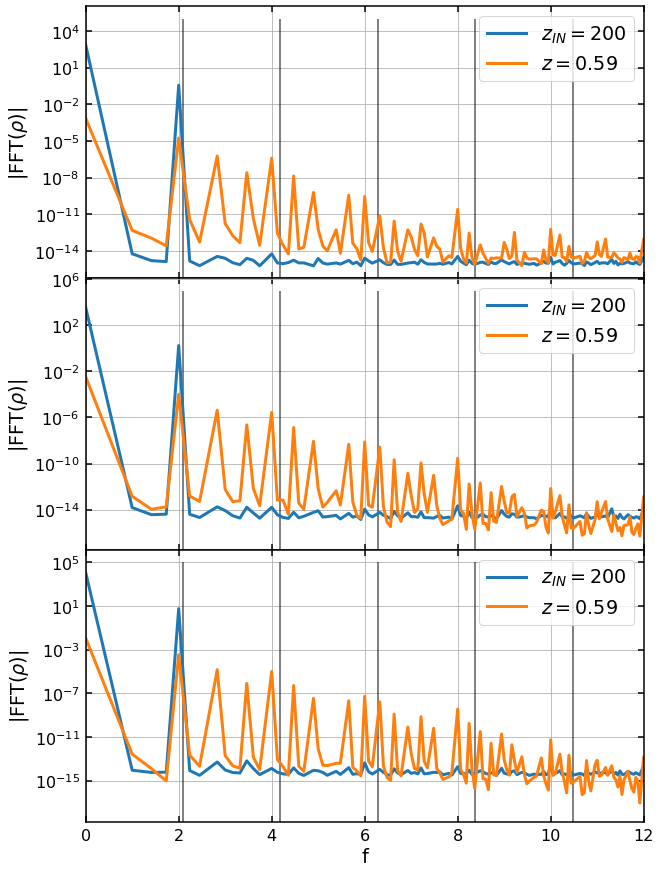

In [12]:
#allp = [pk1_04, pk2_04, pk4_04]
allp = [pk2_10, pk2_06, pk2_04]
plt.figure(figsize=(10,15))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

for p, ax in zip(allp, [ax1, ax2, ax3]):
    FFTC = FFTClass(p)
    for h in range(1,8):
        ax.vlines(x = h*p.ki, ymin=0, ymax=1e5, color='k', alpha=0.65)
    
    it = 0
    fftrho_xyz, fx = FFTC.get_absfftrho(it)
    fftrho_r, frn = FFTC.radial_profile(fftrho_xyz, fx)
    fr = frn*max(fx)
    FFTC.plot_dir(ax, fftrho_xyz, fx, fftrho_r, frn, 'C0', r'$z_{IN}=200$')
    
    it = p.it_last
    t = 1+p.dtfac*p.dx_ref*p.it_last
    h = 1
    H0m1 = 2997.9/h
    z = (2*H0m1/(3*t))**(2/3)-1
    fftrho_xyz, fx = FFTC.get_absfftrho(it)
    fftrho_r, frn = FFTC.radial_profile(fftrho_xyz, fx)
    fr = frn*max(fx)
    FFTC.plot_dir(ax, fftrho_xyz, fx, fftrho_r, frn, 'C1', r'$z=$'+"{:.2f}".format(z))
    
    plt_format(ax)
    
    #ax.text(24.45, 1e-3, r'$\lambda_{pert}=L/$'+str(p.nbrModes), bbox=dict(facecolor='white', alpha=0.85))
    ax.legend(loc='best')
    ax.set_xlim(0, 12)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xlabel('f')
plt.subplots_adjust(hspace=0)
#plt.savefig('/home/robynm/Documents/Major_Review/FFT')